# EDSA - Climate Change Belief Analysis
#### Classification_TS3_DSFT21
------------------------------

<img src="images/Adaptacion_746x419.jpg"
     style="float: center; padding-bottom=0.5em"
     width=600px/>   
-------------------------------

## Table of Contents

1. <a href ="#1.-Challenge-description">Challenge description</a>
2. <a href ="#2.-Introduction">Introduction</a>
3. <a href ="#3.-Importing-Libraries">Importing Libraries</a>
4. <a href ="#4.-Importing-Data">Importing Data</a>
5. <a href ="#5.-Data-Preprocessing">Data Preprocessing</a>
6. <a href ="#6.-Exploratory-Data-Analysis">Exploratory Data Analysis</a>


# 1. Challenge description

Many companies are built around lessening one's environmental impact or carbon foot print. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climante change and whether or not they belive it is a real threat. This would add to their market research efforts in gaugin how their product/service may be received.

With this context, EDSA is challending us during the Classification Sprint with the task of creating a Machine Learning mode that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to the task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


# 2. Introduction

To achieve this, we shall perform preprocessing of the data, statistical and exploratory data analysis, construct multiple machine learning models, train our models with regards to the sentiment expressed by the user and of course testing our model on unseen data to verify the validity of our model.

# 3. Importing Libraries

In this notebook we shall be importing various python libraries to assist with constructing our classification model.

In [2]:
import nltk

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
from string import punctuation
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter


# set plot style
sns.set(style = 'whitegrid')

In [3]:
#Downloading NLTK Corpora
nltk.download(['punkt','stopwords'])

#Downloading wordnet for lemmatisation
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 4. Importing Data

In [4]:
#Training set
train_df = pd.read_csv('data/train.csv')
#Test set
test_df = pd.read_csv('data/test.csv')

## 4.1 Data Overview

Our training set consist of 3 columns:
* The sentiment : Indicates the sentiment of the tweet message
* message : The body of the tweet
* tweetid : Twitter unique id

In [5]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


We look at the top rows of our data to the see the features as well as the types of data we are working with.

In [6]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


Let us get the dimensions of our data to figure out how many observations we have.

In [7]:
np.shape(train_df)

(15819, 3)

We have 15 819 Observations in our data.

Let us get the types of sentiments that are there and their descriptions.

In [8]:
list(train_df['sentiment'].unique())

[1, 2, 0, -1]

There are three class namely :
* 1 Pro: the tweet supports the belief of man-made climate
* 2 News: the tweet links to factual news about climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

Now Let's obtain the counts of each class of sentiments and plot them on a bar graph

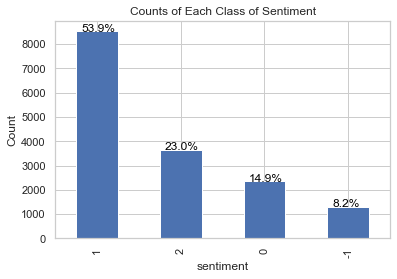

In [9]:
ax = train_df['sentiment'].value_counts().plot(kind = 'bar', 
                                          title = 'Counts of Each Class of Sentiment',
                                          xlabel = 'sentiment', 
                                          ylabel = 'Count')
n_obs = [i.get_height() for i in ax.patches]
total = sum(n_obs)

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.06, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=12,
                color='black')

From the figure above, we observed that we have unbalanced classes. 
* The majority of tweets (53.9%) support the belief of man-made climate change. 
* 23% consist of factual news regarding climate change. 
* 14.9% are neutral about man-made climate change
* 8.2% don't believe in man-made climate change

### Duplicate Tweets

There may be some duplicates tweets in the 'message' column in our data. Let's investigate

In [10]:
# There are duplicate of the same message, possibly due to RT

dup_mes  = len(train_df) - train_df['message'].nunique()
print("Duplicate messages: ", dup_mes)

Duplicate messages:  1590


There are 1590 duplicate messages in the 'message' column

### Hashtag Extraction

Does Hashtags provide any meaningful insight into the sentiment?

In [11]:
def hash_ext(col):
    
    hashtags = []
    
    for i in col:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
        
    hashtags = sum(hashtags, [])
    frequency = nltk.FreqDist(hashtags)
    
    hashtag_df = pd.DataFrame({'hashtag': list(frequency.keys()),
                       'count': list(frequency.values())})
    hashtag_df = hashtag_df.nlargest(15, columns="count")

    return hashtag_df

# Extracting the hashtags from tweets in each class
pro = hash_ext(train_df['message'][train_df['sentiment'] == 1])
anti = hash_ext(train_df['message'][train_df['sentiment'] == -1])
neutral = hash_ext(train_df['message'][train_df['sentiment'] == 0])
news = hash_ext(train_df['message'][train_df['sentiment'] == 2])

In [12]:
anti.head()

,hashtag,count
30,MAGA,11
48,climate,10
12,Trump,7
72,climatechange,6
7,OpChemtrails,4


## 4.2 Balancing data

Imbalanced data raises a commmon issue in classification machine learning algorithm. 

When there are too few observations for a class, the model may not effectively learn the decision bhoundary.

Imbalance classes in the training data, thereby compromises the accuracy of the model. 

Here, we will explore several ways to circumvent the data imbalance.

### 4.2.1 Upsampling

Upsampling is the process of randomly and repetively sampling the minority class to reinforce its siganl.

This can be done by sampling the minority class with replacement.

<br>

From the sentiment count analysis, we have found that our data is imbalanced

The majority of the sentiment is based on class 1, which supports the existence of climate change (pro).

In [20]:
# Separating majority and minority classes

news_df  = train_df[train_df['sentiment'] == 2]
pro_df  = train_df[train_df['sentiment'] == 1]
neut_df = train_df[train_df['sentiment'] == 0]
anti_df = train_df[train_df['sentiment'] == -1]

print('Total News tweets: ', len(news_df), '\n'
        'Total Pro tweets: ', len(pro_df), '\n'
        'Total Neutral tweets: ', len(neut_df), '\n'
        'Total Anti tweets: ', len(anti_df))

Total News tweets:  3640 
Total Pro tweets:  8530 
Total Neutral tweets:  2353 
Total Anti tweets:  1296


As expected, the number of "Pro" climate change tweets outnumber other tweet classes.

We will use the number of class 1 tweets to resample the minority classes.

In [21]:
# Importing resampling module from sklearn
from sklearn.utils import resample

In [24]:
# Upsampling the minority classes

news_df_up = resample(news_df,
                      replace = True,
                      n_samples = 8530,
                      random_state = 1)

neut_df_up = resample(neut_df,
                      replace = True,
                      n_samples = 8530,
                      random_state = 1)

anti_df_up = resample(anti_df,
                      replace = True,
                      n_samples = 8530,
                      random_state = 1)

# Concatanate the majority class and the upsampled minority classes
upsampled_df = pd.concat([pro_df, news_df_up, neut_df_up, anti_df_up])


In [27]:
# Counting the upsampled classes
upsampled_df['sentiment'].value_counts()

 0    8530
 1    8530
 2    8530
-1    8530
Name: sentiment, dtype: int64

### 4.2.2 Downsampling

Downsampling is the opposite of upsampling, wherein the observations in the majority class

is randomly removed to avoid domination of the data.

The data is downsampled by being sampled **without** replacement

<br>

The 'Anti" climate change tweet is the least abundant class in our data with only 1296 observations.

In [29]:
# Downsampling the majority classes

news_df_down = resample(news_df,
                      replace = False,
                      n_samples = 1296,
                      random_state = 1)

neut_df_down = resample(neut_df,
                      replace = False,
                      n_samples = 1296,
                      random_state = 1)

pro_df_down = resample(pro_df,
                      replace = False,
                      n_samples = 1296,
                      random_state = 1)

# Concatanate the minorty class and the downsampled majority classes
downsampled_df = pd.concat([anti_df, news_df_down, neut_df_down, pro_df_down])


In [30]:
# Counting the downsampled classes
downsampled_df['sentiment'].value_counts()

 0    1296
 1    1296
 2    1296
-1    1296
Name: sentiment, dtype: int64

### 4.2.3 Synthetic Minority Oversampling Technique (SMOTE)

Upsampling resolves the data imbalance by sampling the existing observation with replacement.

However, this does not provide any additional information to the model.

<br>

SMOTE works by synthesising new observations from the existing examples in the minority classes.

In bried, a random observations is chosen from the minority class, then k (usually 5) of the nearest

neighbours are found and one is randomly chosen. The synthetic observation is created at a randomly

selected point between the two existing examples in the feature space. As a result, SMOTE not only

increase the number of minority classes but also provide somewhat informative addtion for the model.

In [ ]:
# Install imbalanced-learn lobrary
#pip install imbalanced-learn

# 5. Data Preprocessing

### 5.1. Noise Removal


We started removing all the urls.


In [31]:
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'

train_df['clean_message'] = train_df['message'].replace(to_replace = pattern_url, value = '', regex = True)

Followed by the twitter mentions:


In [32]:
mentions = r'@[\w]*'

train_df['clean_message'] = train_df['clean_message'].replace(to_replace = mentions, value = '', regex = True)

We removed the hashtags:


In [33]:
hashtags = r'#[\w]*'

train_df['clean_message'] = train_df['clean_message'].replace(to_replace = hashtags, value = '', regex = True)

We removed the punctuation

In [34]:
train_df['clean_message'] = train_df['clean_message'].apply(lambda x: ''.join(i for i in x if i not in punctuation))

We changed all the words to lowercase:

In [35]:
train_df['clean_message'] = train_df['clean_message'].str.lower()

Finally we removed all the characters that are not alphabets
* Maybe leave the numbers behind? 

In [36]:
train_df['clean_message'] = train_df['clean_message'].str.replace('[^a-z]', ' ',regex = True)

In [37]:
train_df.head()

,sentiment,message,tweetid,clean_message
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researchers say we have three years to act...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,wired was a pivotal year in the war on ...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt its and a racist sexist climate chang...


### 5.2. Tokenisation

In [38]:
#We first initialise our tokenizer
tokeniser = TreebankWordTokenizer()
train_df['tokens'] =train_df['clean_message'].apply(tokeniser.tokenize)

In [39]:
train_df.head()

,sentiment,message,tweetid,clean_message,tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,"[its, not, like, we, lack, evidence, of, anthr..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researchers say we have three years to act...,"[rt, researchers, say, we, have, three, years,..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,wired was a pivotal year in the war on ...,"[wired, was, a, pivotal, year, in, the, war, o..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt its and a racist sexist climate chang...,"[rt, its, and, a, racist, sexist, climate, cha..."


### 5.3. Retrieving Base Forms

Retrieving Base Forms involves taking words and generating their root form. One should always be caref There are 2 primary techniques for text normalisation namely:
* Stemming
* Lemmatization

N.B. Should exercise caution because many times the context of a word is lost when itis converted to its base form.


We will be using Lemmatization although it's a bit slower than stemming

In [40]:
lemmatizer = WordNetLemmatizer()

train_df['tokens'] = train_df['tokens'].apply(lambda y: [lemmatizer.lemmatize(i) for i in y])

In [41]:
train_df.head()

,sentiment,message,tweetid,clean_message,tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,"[it, not, like, we, lack, evidence, of, anthro..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researchers say we have three years to act...,"[rt, researcher, say, we, have, three, year, t..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,wired was a pivotal year in the war on ...,"[wired, wa, a, pivotal, year, in, the, war, on..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt its and a racist sexist climate chang...,"[rt, it, and, a, racist, sexist, climate, chan..."


### 5.4. Stop Words Removal

In [42]:
train_df['tokens'] = train_df['tokens'].apply(lambda z: [i for i in z if i not in stopwords.words('english')])

In [43]:
# clean_message without stop words
train_df.head()

,sentiment,message,tweetid,clean_message,tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,"[like, lack, evidence, anthropogenic, global, ..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researchers say we have three years to act...,"[rt, researcher, say, three, year, act, climat..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,wired was a pivotal year in the war on ...,"[wired, wa, pivotal, year, war, climate, change]"
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt its and a racist sexist climate chang...,"[rt, racist, sexist, climate, change, denying,..."


### 5.5 Part of Speech

Part of Speech (POS) taggin is the process of assigning a particular part of speech to the text 

based on the definition and context. 

<br>

POS tags provides linguisitic criteria to the model in addition to the statistics.

In [46]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [53]:
from nltk import pos_tag

train_df['PoS'] = train_df['tokens'].apply(lambda a: pos_tag(a))

In [54]:
train_df.head()

,sentiment,message,tweetid,clean_message,tokens,Pos,PoS
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb...","[(polyscimajor, JJ), (epa, NN), (chief, NN), (...","[(polyscimajor, JJ), (epa, NN), (chief, NN), (..."
1,1,It's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,"[like, lack, evidence, anthropogenic, global, ...","[(like, IN), (lack, NN), (evidence, NN), (anth...","[(like, IN), (lack, NN), (evidence, NN), (anth..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researchers say we have three years to act...,"[rt, researcher, say, three, year, act, climat...","[(rt, NN), (researcher, NN), (say, VBP), (thre...","[(rt, NN), (researcher, NN), (say, VBP), (thre..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,wired was a pivotal year in the war on ...,"[wired, wa, pivotal, year, war, climate, change]","[(wired, VBN), (wa, NNS), (pivotal, JJ), (year...","[(wired, VBN), (wa, NNS), (pivotal, JJ), (year..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt its and a racist sexist climate chang...,"[rt, racist, sexist, climate, change, denying,...","[(rt, JJ), (racist, NN), (sexist, NN), (climat...","[(rt, JJ), (racist, NN), (sexist, NN), (climat..."


## 6. Exploratory Data Analysis

Now let's us study the distribution of the length of the words
* First we obtained a list containing all the words
* We obtained the lenth of each word and counted the number of times the word appears in our list
* we grouped frequencies by lenght and summed them up.

In [33]:
word_list =  train_df['tokens'].values
all_words_ls=[word_list[i][j] for i in range(len(word_list)) for j in range(len(word_list[i]))]
word_length_each =pd.DataFrame([[len(i),all_words_ls.count(i)] for i in set(all_words_ls)], 
                               columns = ['word_length','frequency'])

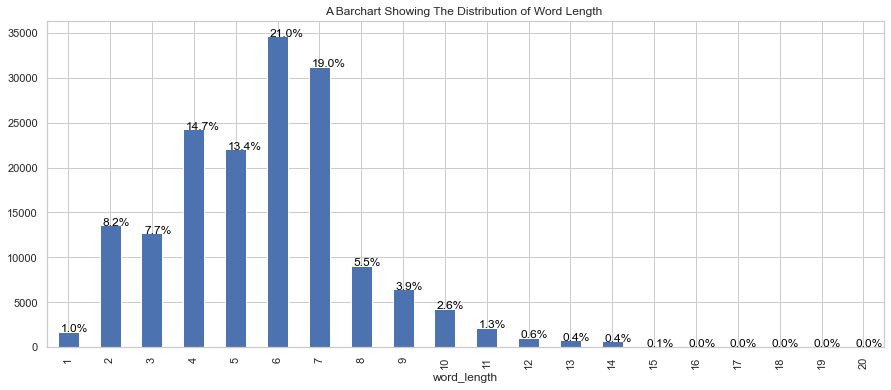

In [36]:
word_length_freq = word_length_each.groupby('word_length')['frequency'].sum().head(20).plot(kind ='bar', 
                                                                                           title = "A Barchart Showing The Distribution of Word Length ", 
                                                                                           figsize = (15,6))
n_obs = [i.get_height() for i in word_length_freq.patches]
total = sum(n_obs)

for i in word_length_freq.patches:
    # get_x pulls left or right; get_height pushes up or down
    word_length_freq.text(i.get_x()+0.06, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=12,
                color='black')

The lengths of the words ranged from 1-70, to obtain a better visualisation we limited the domain to words of lengths 1-2The length of the words appears to be positively skewed. We can expect the data to contain outliers to the right of the distribution. Most words lengths (78.4%) lies between 3-8,with the peak being 7.

We investigated words with lengths greater than 20 and the outcome is displayed below

In [37]:
greater_than_20 = [i for i in all_words_ls if len(i)>20]
print(greater_than_20)

['technologysehipnotize', 'housesufosangelsbigfoot', 'nationalinternational', 'hahahahahahaahahahahahahaahahahaha', 'businessampacademician', 'politiciansscientists', 'affiliationagesexnationality', 'capsgtdrillingextracting', 'channelsfeeddigestcomnewsid', 'emotionalpsychological', 'universityofnairobiuonstudents', 'antiimmigrationterrorism', 'bigpictureperspective', 'npoliticiansampscientificdepartmentsanymoretheyarecoveringtherealityof', 'capitalistbillionaire', 'geographicallyvarying', 'freefrecansednegative', 'inspectnafforestationpollution', 'farmersecorestoration']


From the above,we saw the words are nonsensical (mashup of words). And since they form small part of our sample we decided to remove them.

In [38]:
train_df['tokens'] = train_df['tokens'].apply(lambda x : [i for i in x if i not in greater_than_20])

Making the 'clean_message' column to match the content in tokens

In [39]:
train_df['clean_message'] = train_df['tokens'].apply(lambda a: ' '.join([i for i in a]))

In order to identify the most common words tweeted, we plotted the wordcloud of all the words in our clean corpus. A bigger font implies higher frequency.

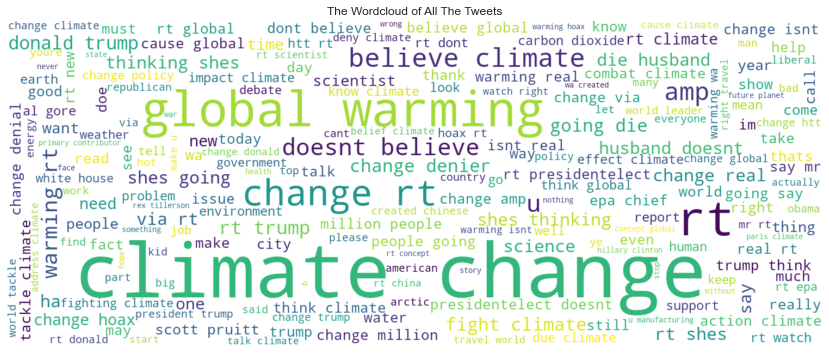

In [40]:
all_words = ' '.join([text for text in train_df['clean_message']])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(all_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud of All The Tweets')
plt.show()

From The above we can see that our data still has a bit of noise. We might need to remove words of length less than 3.



We then obtained the most occurring words tweets that do not believe in man-made climate change

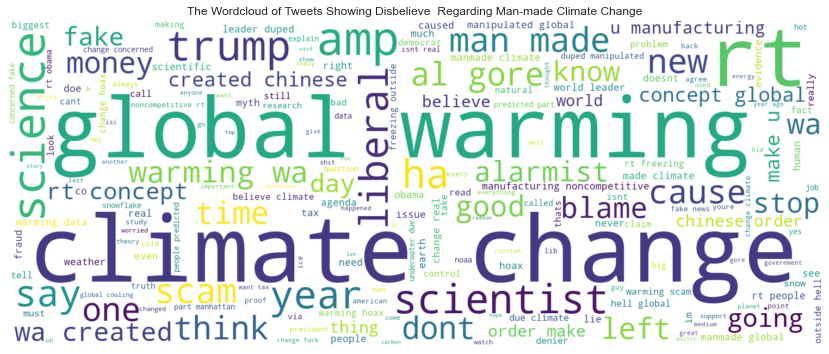

In [41]:
neg_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == -1]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(neg_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud of Tweets Showing Disbelieve  Regarding Man-made Climate Change')
plt.show()

We obtained the most frequently used words to tweets that displayed belief in man-made climate change

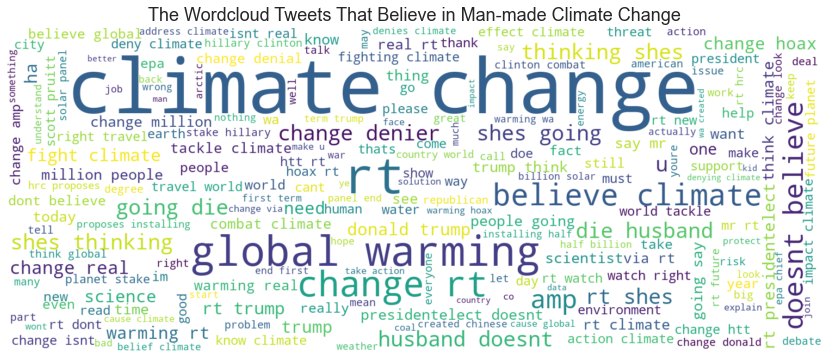

In [289]:
pro_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 1]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(pro_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud Tweets That Believe in Man-made Climate Change')

plt.show()

Neutral

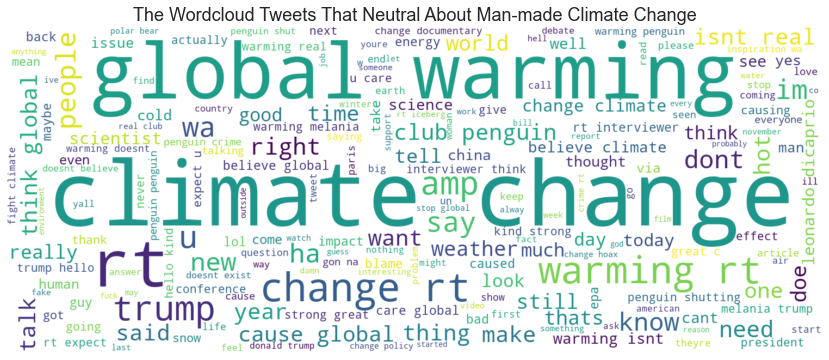

In [290]:
neutral_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 0]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(neutral_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud Tweets That Neutral About Man-made Climate Change')
plt.show()

Factual News about man-made cimate change

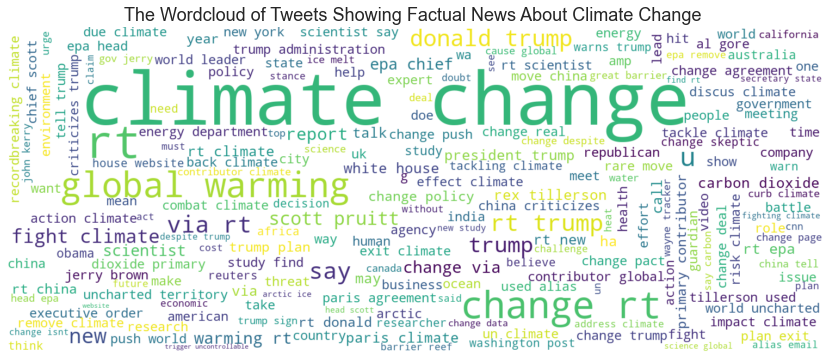

In [293]:
news = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 2]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(news)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud of Tweets Showing Factual News About Climate Change ')
plt.show()

Our analysis above indicated that we might need to remove words with length 1 and 2. Words such as rt  and $\tilde{a}$. So we limited our analysis to these lengths to see the most frequenty occuring words.


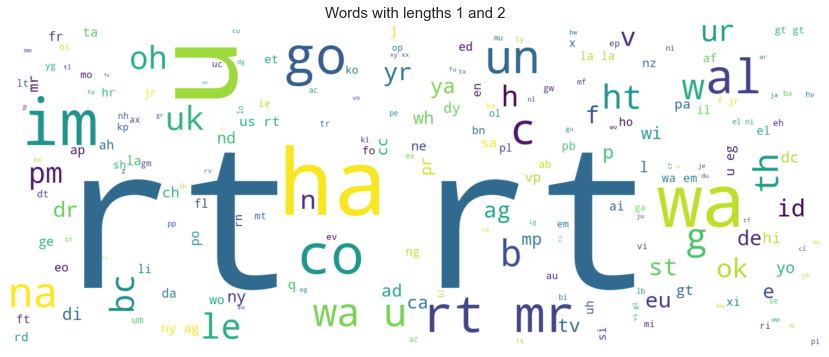

In [295]:
len_12 = ' '.join([i for i in all_words_ls if len(i)<3])
neg_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 2]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(len_12)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words with lengths 1 and 2', fontsize=15)
plt.axis('off')
plt.show()

The words above were regarded as noise. We decided to remove all the words with a length less than 3.

In [42]:
less_than_3 = [i for i in all_words_ls if len(i)<3]

train_df['tokens'] = train_df['tokens'].apply(lambda x : [i for i in x if i not in less_than_3])

In [43]:
train_df.head()

,sentiment,message,tweetid,clean_message,tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming,"[like, lack, evidence, anthropogenic, global, ..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researcher say three year act climate chang...,"[researcher, say, three, year, act, climate, c..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,wired wa pivotal year war climate change,"[wired, pivotal, year, war, climate, change]"
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt racist sexist climate change denying bigot ...,"[racist, sexist, climate, change, denying, big..."


## 7. Feature Extraction
In this section we tried different techniques for feature extraction, we tried each of the following techniques to see the one that gives us the best performance:

7.1. <a href ="#7.1.-Bag-of-Words">Bag of Words</a>


### 7.1. Bag of Words

Bag of words ignores any information about the ordering or the structure of the words in our corpus. Its only concern is the occurence of the word(s). It takes in a list containing all the clean words in our corpus and returns a dictionary containing the unique words as keys and their frequencies as values. The algorithm can be configured to take in single words or take a group of words (those attained through Ngrams. The image below shows the former but the same rules apply for $n>1$.

<img src="images/bag_of_word1.png"
     style="float: center; padding-bottom=0.5em"
     width=600px/>
     
For each and every row, the text is going to be vectorized by in this form:
<img src="images/bag_of_word3.png"
     style="float: center; padding-bottom=0.5em"
     width=600px/>


In [44]:
all_words_clean =[train_df['tokens'].values[i][j] for i in range(len(train_df['tokens'].values)) for j in range(len(train_df['tokens'].values[i]))]
bow = Counter(all_words_clean)
clean_bow_df = pd.DataFrame.from_records(list(dict(bow.most_common(20)).items()), columns=['word','count'])

Below is a vertical barchat showing the top 20 common words.

<AxesSubplot:title={'center':'Top 20 Common Words'}, ylabel='Word'>

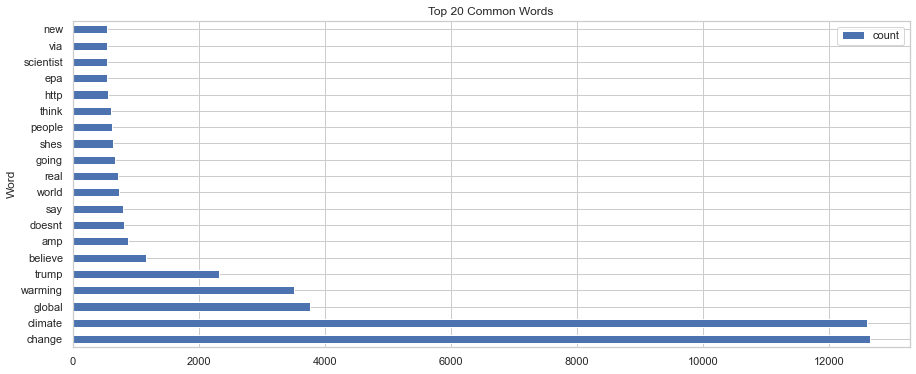

In [45]:
clean_bow_df.plot(x='word', y='count', kind='barh', title ='Top 20 Common Words', 
                  xlabel = 'Word', ylabel = 'Frequency', figsize = (15,6))

In [46]:
clean_bow_df['count'].min()


541